# LuSEE-Night Simulation
#### David W. Barker
## Purpose
The purpose of this notebook is to create a LuSEE-Night simulation (end-to-end). There are two primary things being done in this simulation: 1) a simulated signal and 2) a large number of simulated signals with varying parameters that create the traning sets. You then see if your training set's eigen vectors can model the arbitrary simulated signal. That's the main goal.

In [1]:
# boiler plate for most pylinex 21-cm stuff

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
import py21cmfast as p21c
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
import ares
import camb

## The 21 cm Signal
Our first step is to create a training set for the 21 cm signal. This should include not only differences in the cosmological parameters, but also phenomenological models of increase heating and cooling.

### STEP 1: Code Up An Analytical Solution to the Dark Ages Signal.

#### Step 1.1: Derive an analytical solution for the Dark Ages signal.
We did this in our "Derivations for Comps" notebook, so let's repeat what we need here:

- $\delta T_{b}(\nu)=\frac{T_{b}(\nu)-T_{\gamma(\nu)}}{1+z}$ (1)

However, this is perhaps unneccesary (or very neccesary, not sure) so let's simplify to the following (UPDATE: Its super necessary. Use equation 18):

- $\delta T_{b} = T_{S} - T_{\gamma}$ (2)

where $T_{S}$ is the spin temperature and $T_{\gamma}$ is the CMB temperature. Now lets start the process of expanding these terms out until we get to the point that we can plug in constants and code this up:

- $T_{S} = \frac{1+x_{c}}{{\frac{1}{T_{\gamma}}+\frac{x_{c}}{T_{k}}}}$ (3)

We have $T_{\gamma}$:

- $T_{\gamma} = T_{\gamma,0}(1+z) = 2.725(1+z)K $  (4)

where z is our independent variable and $T_{\gamma,0}$ = 2.725 K. Still need $x_{c}$ and $T_{k}$:

- $x_{c}^{i}\equiv \frac{C_{10}^{i}}{A_{10}}\frac{T_{\star}}{T_{\gamma}} = \frac{n_{i}k_{10}^{i}}{A_{10}}\frac{T_{\star}}{T_{\gamma}}$ (5)

the i denotes the different collision species. The two we care about the most are other Hydrogen atoms and free electrons. There are other things like Helium (only ionized helium due to spin conservation) and Deuterium, but they are very minimal in their contribution. If we are way off with our calculation, this approximation doesn't seem a likely culprit, but it's good to keep in mind that it is, in fact, an approximation. So if we consider the two species:

- $x_{c} = \frac{T_{\star}}{T_{\gamma}A_{10}}(n_{H}\kappa_{10}^{HH}+n_{e}\kappa_{10}^{eH})$ (6)

where $HH$ means collisions between hydrogen atoms and $eH$ means collisions between hydrogen and free electrons. We still need the $n$ 's: I don't love that I'm still ignoring Helium, even when considering number density, but I see that in the literature, so maybe it's okay to do.  If our signal is way off this might be a good place to start to correct approximations.

- $n_{e} = n_{b}x_{e}$ (7)

- $n_{H} = n_{b}(1-x_{e})$ (8)

- $n_{b} = n_{b,0}(1+z)^{3} = 2.06 \times 10^{-7}(1+z)^3$ $\frac{baryons}{cm^{3}} $ (9)

where $n_{b,0}=2.06 \times 10^{-7}$ $\frac{baryons}{cm^{3}} $ (10)

We will grab $x_{e}$ from CosmoRec. Here are some important constants and formulas we know that will allow us to get to an $x_{c}$ that is actually programmable:

- $A_{10} = 2.85 \times 10^{-15}$ $s^{-1}$ (11)

- $T_{\star} = 0.068$ $K$ (12)

- $\kappa_{10}^{HH}$ will be interpolated from a table on pg. 29 of Furlanetto, et al. 2006b (13)

- $\kappa_{10}^{eH}$ will be interpolated from a table on pg. 30 of Furlanetto, et al. 2006b (14)

And now we have all we need to get to something programmable:

- $x_{c} = \frac{T_{\star}}{T_{\gamma,0}(1+z)A_{10}}(n_{H}\kappa_{10}^{HH}+n_{e}\kappa_{10}^{eH})$ (15)

- $T_{S} = \frac{1+x_{c}}{{\frac{1}{T_{\gamma,0}(1+z)}+\frac{x_{c}}{T_{k}}}}$ (16)

- $\frac{dT_{k}}{dt} = \frac{x_{e}}{1+f_{He}+x_{e}}\frac{(T_{\gamma,0}(1+z)-T_{k})}{t_{c}}-2T_{k}H$ (17)

Where $f_{He}$ is the fraction of the gas that is helium (by number, not by mass). Turns out most references ignore this term, which caused days of investigating to figure out why my code was slightly off from others. Now we're good!
This is the equation for $\delta T_{b}$ that you have to use to get accurate results. You can't ignore the extinction of these signals as they travel to us.

- $\delta T_{b}(\nu)\approx 27x_{HI}(\frac{h^{2}\Omega_{b,0}}{0.023})[\frac{0.15}{h^2\Omega_{m,0}}\frac{(1+z)}{10}]^{1/2}[1-\frac{T_{\gamma}(z)}{T_{S}}]mK$

For our initial test, I'm not going to bother running any code for $T_{k}$ I'm going to let CosmoRec handle that. Once wer're confident everything else works, we can add in our own $T_{k}$ calculator so that we may add some phenomenological shananigans to it later on if we desire (and also prove I understand what's going on and can code it up).

Okay, so let's code up equations 2, 15, and 16, and use CosmoRec for $T_{k}$ for now and see what we get.

In [2]:
# Some basic constants
kb = 1.3807e-16     # Boltzman's constant [ergs per Kelvin]
# Parameters  (Taking the Lambda CDM ones from Planck collaboration 2020 pg.19 (without BAO because of no real reason))
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05
omL0 = 0.6847   # Omega Dark Energy today
f_He = 0.136    # Fraction of Helium by number of electrons
z_array = np.arange(20,1100)
n_b0 = 2.06e-7   #[baryons per cubic centimeter] This actually a function of Omega baryons, but I don't want to figure that out right now (just want to prove it works first).
T_gamma0 = 2.725   # [Kelvin] modern CMB temperature
T_star = 0.068    # [Kelvin] the temperature equivalent of the energy difference of the 21 cm hyperfine spin states
A_10 = 2.85e-15    # [inverse seconds] Einstein coefficient for the spontaneous emission of the hyperfine spin states
# Less neccesary (or at least less understood by me but needed by some code)
As = 2.099e-9  # Amplitude of a power spectrum of adiabatic perturbations
ns = 0.9649    # Spectra index of a power spectrum of adiabatic perturbations

In [3]:
# x_e
# for starters, I'm just going to use CosmoRec. We'll use camb later so it's more flawlessly integrated into python

CosmoRec_raw=np.genfromtxt("CosmoRec.dat")
CosmoRec_xe = scipy.interpolate.interp1d(CosmoRec_raw.transpose()[0],CosmoRec_raw.transpose()[1])   # Needs a redshift argument
CosmoRec_Tk = scipy.interpolate.interp1d(CosmoRec_raw.transpose()[0],CosmoRec_raw.transpose()[2])   # Needs a redshift argument

# Alternative x_e:

xe_alt = lambda z: 0*(z/z)

# x_e using camb
parameters_camb = camb.set_params(H0=H0, ombh2=omB0*h**2, omch2=omC0*h**2, As=As, ns=ns)
camb_data= camb.get_background(parameters_camb)
camb_xe = camb_data.get_background_redshift_evolution(z_array, ["x_e"], format="array")
# or if you want an interpolated version:
camb_xe_interp = scipy.interpolate.CubicSpline(z_array,camb_xe.flatten())  # Needs a redshift argument

In [4]:
# This is our custom T_k code

def Tk (z_array):
    """Creates an array evolving the IGM temperature based on adiabatic cooling and compton scattering. Only works for the cosmic 
    Dark Ages, as it does not include UV
    
    ===================================================================
    Parameters
    ===================================================================
    z_array: an array of increasing redshift values. Needs to be a sufficiently fine grid. 
    As of now there is some considerable numerical instabilities when your z grid is > 0.01
    ===================================================================
    Output
    ===================================================================
    Tk_array:  A 2-D array with each entry being the redshift and IGM temperature
    Tk_function: Interpolated version of your Tk_array that acts like a function with
    redshift for its argument. Useful for future calculations."""
### Let's code up T_k
    num=len(z_array)
    t_c = lambda z: 1.172e8*((1+z)/10)**(-4) * 3.154e7 #[seconds] timescale of compton scattering
    T_gamma = lambda z: T_gamma0*(1+z)   # evolution of the CMB temp
    H = lambda z: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(omL0/((1+z)**2)))  # Hubble flow function with a conversion factor
    # zlog = np.logspace(np.log10(z_array[0]),np.log10(z_array[-1]),num=num)[::-1]
    # zlog = np.append(zlog,0)
    zlog = z_array[::-1]
    T = T_gamma(z_array[-1])   # your initial temperature at the highest redshift. This assumes it is coupled fully to the CMB at that time.
    ze = z_array[-1]           # defines your starting z (useful for the loop below)
    x_e = camb_xe_interp   # this is our model for fraction of free electrons
    Tk_array = np.zeros((num-1,2))
    adiabatic = lambda zs,T,ze:(1/(H(zs)*(1+zs)))*(2*H(zs)*T)*(ze-zs)
    compton = lambda zs,T,ze: (1/(H(zs)*(1+zs)))*((x_e(zs))/(1+f_He+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))*(ze-zs)
    for i in range(num-1):
        zs = ze
        ze = zlog[i+1]
        # adiabatic = lambda zs,T:(1/(H(zs)*(1+zs)))*(2*H(zs)*T)*(ze-zs)
        # compton = lambda zs,T: (1/(H(zs)*(1+zs)))*((x_e(zs))/(1+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))*(ze-zs)
        T += adiabatic(zs,T,ze)-compton(zs,T,ze)    # This is where you would add the phenomenological cooling and heating parts
        Tk_array[i][0] = ze
        Tk_array[i][1] = T
    Tk_function=scipy.interpolate.CubicSpline(Tk_array.transpose()[0][::-1],Tk_array.transpose()[1][::-1])  # Turns our output into a function with redshift as an argument    
    return Tk_array, Tk_function

In [5]:
# Runs my own T_k function for later input. Re run this when you change cosmological parameters
z_array_Tk=np.arange(20,1100,0.01)     # this function needs a finer Tk because of some numerical instability (should look into that)
My_Tk=Tk(z_array_Tk)

In [6]:
### Here is the stuff that generally doesn't change

## Here are the k tables from Furlanetto 2006b

k_HH_raw = np.array([[1,1.38e-13],[2,1.43e-13],[4,2.71e-13],[6,6.60e-13],[8,1.47e-12],[10,2.88e-12],[15,9.10e-12],[20,1.78e-11],[25,2.73e-11],[30,3.67e-11],[40,5.38e-11],[50,6.86e-11],[60,8.14e-11],[70,9.25e-11],\
                 [80,1.02e-10],[90,1.11e-10],[100,1.19e-10],[200,1.75e-10],[300,2.09e-10],[500,2.56e-10],[700,2.91e-10],[1000,3.31e-10],[2000,4.27e-10],[3000,4.97e-10],[5000,6.03e-10]])
k_eH_raw = np.array([[1, 2.39e-10],[2,3.37e-10],[5,5.30e-10],[10,7.46e-10],[20,1.05e-9],[50,1.63e-9],[100,2.26e-9],[200,3.11e-9],[500,4.59e-9],[1000,5.92e-9],[2000,7.15e-9],[3000,7.71e-9],[5000,8.17e-9]])

# let's write a function that interpolates this table given whatever value we put in.
k_HH = scipy.interpolate.CubicSpline(k_HH_raw.transpose()[0],k_HH_raw.transpose()[1])   # Needs a temperature (or array of temps) as an argument
k_eH = scipy.interpolate.CubicSpline(k_eH_raw.transpose()[0],k_eH_raw.transpose()[1])   # Needs a temperature (or array of temps) as an argument

## n_H and n_e

n_H = lambda z,x_e: n_b0*(1+z)**3*(1-x_e(z))
n_e = lambda z,x_e: n_b0*(1+z)**3*(x_e(z))


In [7]:
# x_c
# x_c = lambda z,x_e,T_k: (T_star)/(T_gamma0*(1+z)*A_10)*(n_H(z,x_e)*k_HH(T_k(z))+n_e(z,x_e)*k_eH(T_k(z))+50*n_e(z,x_e)*k_eH(T_k(z)))
x_c = lambda z,x_e,T_k: (T_star)/(T_gamma0*(1+z)*A_10)*(n_H(z,x_e)*k_HH(T_k(z))+n_e(z,x_e)*k_eH(T_k(z)))   # HH and eH
# x_c = lambda z,x_e,T_k: (T_star)/(T_gamma0*(1+z)*A_10)*(10*n_H(z,x_e)*k_HH(T_k(z)))

In [8]:
# T_S

T_S = lambda z,x_e,T_k: (1+x_c(z,x_e,T_k))/((1/(T_gamma0*(1+z)))+(x_c(z,x_e,T_k)/T_k(z)))

In [9]:
# But that's not the actual data. Need to include optical depth:

###
# z is your redshift (can be an array or single value)
# x_e is your fraction of free electrons functions (with z as an argument)
# T_k is your gas temperature functions (with z as an argument)
dTb = lambda z,x_e,T_k: 27*(1-x_e(z))*((h**2*omB0)/(0.023))*(((0.15)/(h**2*omM0))*((1+z)/(10)))**(1/2)*(1-((T_gamma0*(1+z))/(T_S(z,x_e,T_k))))

In [11]:
# Now let's compare to 21cmFAST

# 21 cm FAST seems to not appreciate any z value (redshift) of 500 or more. Puts the lower limit of the 
# frequency at around 3 MHZ.  Ideal would be 1 MHz, but LuSEE-Night is at 5 MHz, so I suppose that will
# be fine.  May want to look into getting that down to 1 somehow someday, but not right now.
### for converting from redshift to frequency
# frequencies_21cm = np.arange(3,200)  # avoiding anything below 2.5 MHZ
# z = lambda f: 1420.4/f-1
# z_array = np.array([])
# for i in frequencies_21cm:
#     element = z(i)
#     z_array=np.append(z_array,element)
# Now let's plug in the redshifts
z_array_21cmfast=np.arange(20,1100)
coeval_boxes = p21c.run_coeval(
    redshift = list(z_array_21cmfast[0:450]),
    user_params = {"HII_DIM": 100, "BOX_LEN": 100, "USE_INTERPOLATION_TABLES": True},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8159,hlittle=h,OMm=omM0,OMb=omB0,POWER_INDEX=ns),
    astro_params = p21c.AstroParams(),
    flag_options = {'USE_TS_FLUCT':True},
    random_seed=12345)
# Let's make our 21cm curve from the data!
global21cm_array=np.array([])
for i in range(len(z_array[0:450])):
    element=coeval_boxes[i].brightness_temp.mean()
    global21cm_array=np.append(global21cm_array,element)

# This will plot our data over our frequencies_21cm / or z array (depending on what I'm doing)
# fig=plt.figure(figsize=(20,5))
# plt.plot(z_array[0:450],global21cm_array)
# plt.xlabel(r'redshift',size=15)
# plt.ylabel(r'Temperature Residual $\delta T_{b} (mK)$',size=15)
# plt.title("Global 21-cm Signal", size = 20)
# plt.show()

In [12]:
 FAST_interp = scipy.interpolate.CubicSpline(z_array_21cmfast[0:450],global21cm_array)

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_558/1743401394.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel(f"$\delta T_b$ $[mK]$")


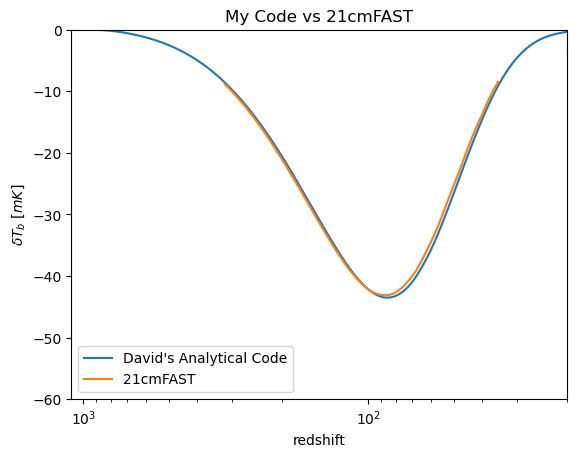

In [224]:
# comparison of my analytical code vs 21cmFAST

plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk[1]),label="David's Analytical Code")
# plt.plot(ARES_redshift,ARES_dTb, label="ARES")
# plt.plot(z_array[15:300],FAST_interp(z_array[15:300]),label="21cmFAST")
plt.plot(z_array[15:300],FAST_interp(z_array[15:300]),label="21cmFAST")
# plt.plot(z_array,dTb(z_array,CosmoRec_xe,CosmoRec_Tk),label="CosmoRec Tk")
# plt.plot(z_array,dTb(z_array,camb_xe_interp,camb_test_interp),label="camb_test Tk")
plt.title("My Code vs 21cmFAST")
# plt.axvline(85)
plt.xscale("log")
plt.xlabel("redshift")
plt.ylabel(f"$\delta T_b$ $[mK]$")
plt.xlim(1100,20)
plt.ylim(-60,0)
plt.legend()
plt.savefig("My T_k compared")

In [14]:
# Let's compare the minimums and the locations of the minimums:
David_min=dTb(z_array,camb_xe_interp,My_Tk[1]).min()
David_redshift_min = z_array[np.where(dTb(z_array,camb_xe_interp,My_Tk[1])==David_min)]
print(f"David's code has a minimum of {David_min:.2f} mK at a redshift of {David_redshift_min[0]} or a frequency of {1420/(1+David_redshift_min[0]):.2f} MHz")

FAST_min = global21cm_array.min()
FAST_redshift_min = z_array_21cmfast[np.where(global21cm_array==FAST_min)]
print(f"21cmFAST has a minimum of {FAST_min:.2f} mK at a redshift of {FAST_redshift_min[0]} or a frequency of {1420/(1+FAST_redshift_min[0]):.2f} MHz")

David's code has a minimum of -43.53 mK at a redshift of 86 or a frequency of 16.32 MHz
21cmFAST has a minimum of -43.13 mK at a redshift of 87 or a frequency of 16.14 MHz


#### So it seems my analytical code is very close to the 21cmFAST numerical simulation code. Cool

### Now let's see how easy it is to implement heating and cooling models into our Tk code:

In [21]:
# Additional Cooling

# This is our custom T_k code with additional cooling

def Tk_cool (z_array):
    """Creates an array evolving the IGM temperature based on adiabatic cooling and compton scattering. Only works for the cosmic 
    Dark Ages, as it does not include UV
    
    ===================================================================
    Parameters
    ===================================================================
    z_array: an array of increasing redshift values
    ===================================================================
    Output
    ===================================================================
    Tk_array:  A 2-D array with each entry being the redshift and IGM temperature"""
### Let's code up T_k
    num=len(z_array)
    t_c = lambda z: 1.2e8*((1+z)/10)**(-4) * 3.154e7 #[seconds] timescale of compton scattering
    T_gamma = lambda z: T_gamma0*(1+z)   # evolution of the CMB temp
    H = lambda z: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(omL0/((1+z)**2)))  # Hubble flow function with a conversion factor
    # zlog = np.logspace(np.log10(z_array[0]),np.log10(z_array[-1]),num=num)[::-1]
    # zlog = np.append(zlog,0)
    zlog = z_array[::-1]
    T = T_gamma(z_array[-1])   # your initial temperature at the highest redshift. This assumes it is coupled fully to the CMB at that time.
    ze = z_array[-1]           # defines your starting z (useful for the loop below)
    x_e = camb_xe_interp   # this is our model for fraction of free electrons
    Tk_array = np.zeros((num-1,2))
    for i in range(num-1):
        zs = ze
        ze = zlog[i+1]
        adiabatic = lambda zs,T:(1/(H(zs)*(1+zs)))*(2*H(zs)*T)*(ze-zs)
        compton = lambda zs,T: (1/(H(zs)*(1+zs)))*((x_e(zs))/(1+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))*(ze-zs)
        T += adiabatic(zs,T)-compton(zs,T) + 0.01*zs*(ze-zs)    # This is where you would add the phenomenological cooling and heating parts
        Tk_array[i][0] = ze
        Tk_array[i][1] = T
    Tk_function=scipy.interpolate.CubicSpline(Tk_array.transpose()[0][::-1],Tk_array.transpose()[1][::-1])  # Turns our output into a function with redshift as an argument    
    return Tk_array, Tk_function

In [22]:
# Additional Heating

# This is our custom T_k code with additional cooling

def Tk_heat (z_array):
    """Creates an array evolving the IGM temperature based on adiabatic cooling and compton scattering. Only works for the cosmic 
    Dark Ages, as it does not include UV
    
    ===================================================================
    Parameters
    ===================================================================
    z_array: an array of increasing redshift values
    ===================================================================
    Output
    ===================================================================
    Tk_array:  A 2-D array with each entry being the redshift and IGM temperature"""
### Let's code up T_k
    num=len(z_array)
    t_c = lambda z: 1.2e8*((1+z)/10)**(-4) * 3.154e7 #[seconds] timescale of compton scattering
    T_gamma = lambda z: T_gamma0*(1+z)   # evolution of the CMB temp
    H = lambda z: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(omL0/((1+z)**2)))  # Hubble flow function with a conversion factor
    # zlog = np.logspace(np.log10(z_array[0]),np.log10(z_array[-1]),num=num)[::-1]
    # zlog = np.append(zlog,0)
    zlog = z_array[::-1]
    T = T_gamma(z_array[-1])   # your initial temperature at the highest redshift. This assumes it is coupled fully to the CMB at that time.
    ze = z_array[-1]           # defines your starting z (useful for the loop below)
    x_e = camb_xe_interp   # this is our model for fraction of free electrons
    Tk_array = np.zeros((num-1,2))
    for i in range(num-1):
        zs = ze
        ze = zlog[i+1]
        adiabatic = lambda zs,T:(1/(H(zs)*(1+zs)))*(2*H(zs)*T)*(ze-zs)
        compton = lambda zs,T: (1/(H(zs)*(1+zs)))*((x_e(zs))/(1+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))*(ze-zs)
        T += adiabatic(zs,T)-compton(zs,T) - 0.01*zs*(ze-zs)    # This is where you would add the phenomenological cooling and heating parts
        Tk_array[i][0] = ze
        Tk_array[i][1] = T
    Tk_function=scipy.interpolate.CubicSpline(Tk_array.transpose()[0][::-1],Tk_array.transpose()[1][::-1])  # Turns our output into a function with redshift as an argument    
    return Tk_array, Tk_function

In [25]:
# Let's get a Tk interpolation for these different models
z_array_Tk=np.arange(20,1100,0.01)     # this function needs a finer Tk because of some numerical instability (should look into that)
My_Tk_cool=Tk_cool(z_array_Tk)
My_Tk_heat=Tk_heat(z_array_Tk)


<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_481/3516778845.py:9: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel(f"$\delta T_b$ $[mK]$")


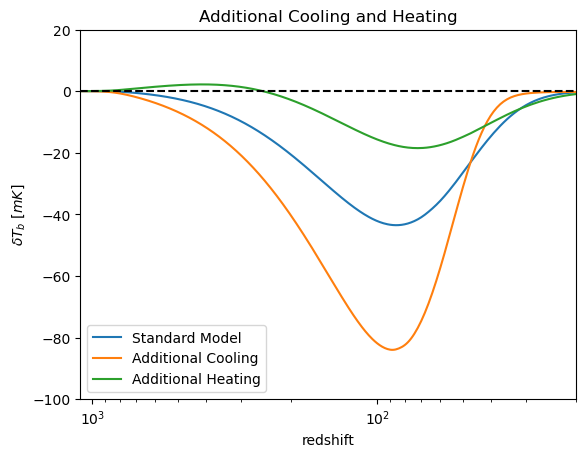

In [26]:
# Let's now plot these different models to see how they change the curve:
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk[1]),label="Standard Model")
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_cool[1]),label="Additional Cooling")
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_heat[1]),label="Additional Heating")
plt.title(f"Additional Cooling and Heating")
# plt.axvline(85)
plt.xscale("log")
plt.xlabel("redshift")
plt.ylabel(f"$\delta T_b$ $[mK]$")
plt.axhline(ls="--",c="black")
plt.xlim(1100,20)
plt.ylim(-100,20)
plt.legend()

In [27]:
# Let's compare the minimums and the locations of the minimums:
David_min=dTb(z_array,camb_xe_interp,My_Tk[1]).min()
David_redshift_min = z_array[np.where(dTb(z_array,camb_xe_interp,My_Tk[1])==David_min)]
print(f"David's code has a minimum of {David_min:.2f} mK at a redshift of {David_redshift_min[0]} or a frequency of {1420/(1+David_redshift_min[0]):.2f} MHz")

cool_min = dTb(z_array,camb_xe_interp,My_Tk_cool[1]).min()
cool_redshift_min = z_array[np.where(dTb(z_array,camb_xe_interp,My_Tk_cool[1])==cool_min)]
print(f"21cmFAST has a minimum of {cool_min:.2f} mK at a redshift of {cool_redshift_min[0]} or a frequency of {1420/(1+cool_redshift_min[0]):.2f} MHz")

heat_min = dTb(z_array,camb_xe_interp,My_Tk_heat[1]).min()
heat_redshift_min = z_array[np.where(dTb(z_array,camb_xe_interp,My_Tk_heat[1])==heat_min)]
print(f"21cmFAST has a minimum of {heat_min:.2f} mK at a redshift of {heat_redshift_min[0]} or a frequency of {1420/(1+heat_redshift_min[0]):.2f} MHz")

David's code has a minimum of -43.53 mK at a redshift of 86 or a frequency of 16.32 MHz
21cmFAST has a minimum of -84.00 mK at a redshift of 88 or a frequency of 15.96 MHz
21cmFAST has a minimum of -18.51 mK at a redshift of 72 or a frequency of 19.45 MHz


#### So implementing cooling and heating is super simple. Great!

### That's great, but now let's code up an actual dark matter annihilation model

We'll be using the model from Chluba 2010:

- Their model:
    - $\Gamma_{dman} = 1.6 \times 10^{-12}f_{dman}g_{h}\epsilon_{0}n_{H}(1+z)^{3}$ $\frac{erg}{cm^{3}s}$
    - Where $\Gamma_{dman}$ is the heating rate associated with the annihilation of dark matter, $f_{dman}$ is the fraction of released energy absorbed by baryonic matter, $g_{h}$ is the fraction of that energy that goes into heating the gas (equation for that listed below), $\epsilon_{0}$ is a dimensionless parameter of the self-annihilation of dark matter particles (equation listed below), $n_{H}$ is the number density of Hydrogen in the gas, and z is redshift. 
    - $g_{h} = (1+2x_{HII}+f_{He}(1+2x_{HeII}))/3(1+f_{He})$
    - where $x_{HII}$ is the fraction of ionized hydrogen, $f_{He}$ is the fraction of helium in the gas (by number, not mass), $x_{HeII}$ is the fraction of the gas that is singly ionized helium.
    - $\epsilon_{0} = 4.26 \times 10^{-28} \left[\frac{100GeV}{m_{dm}}\right]\left[\frac{\Omega_{dm}h^{2}}{0.12}\right]^{2}\left[\frac{\langle \sigma v \rangle}{10^{-29}cm^{3}/s}\right]$
    - Where $m_{dm}$ is the mass of dark matter particles, $\Omega_{dm}$ is the density parameter for dark matter, h is the little h for cosmology, and $\langle \sigma v \rangle$ is the effective cross section of annihilation for the dark matter particles averaged over their velocities.
- If the mass of dark matter is well over 20 eV, then this processs has enough energy to ionize hydrogen and helium atoms, resulting in a change in the usual ionization fractions. The effect is in this equation:
- $(1+z)H\frac{dx_{HI}}{dz}|=0.0735f_{dman}g^{(HI)}_{ion}\frac{\epsilon_{0}n_{H}(1+z)^{3}}{n_{HI}(1+f_{He})}$
  
- $(1+z)H\frac{dx_{HeI}}{dz}|=0.04065f_{dman}g^{(HeI)}_{ion}\frac{\epsilon_{0}n_{H}f_{He}(1+z)^{3}}{n_{HeI}(1+f_{He})}$

- where $g^{(HI)}_{ion} = (1-x_{HII})/3$ and $g^{(HeI)}_{ion} = (1-x_{HeII})/3$ and are the fractions of the release energy that go to the ionization of hydrogen and helium, respectively.
- Notice how around 1/3 of the energy is going into ionization, 1/3 to heating up the gas, and 1/3 to the excitation of the energy levels of the neutral atoms.
- They changed $f_{dman}\epsilon_{0}$ to get a range of curves.
- They noticed that when $f_{dman}\epsilon_{0} > 10^{-24}$ you get noticable changes in the dark ages signal ($10^{-22}$ for cosmic dawn).
- Upper bound based on ionization fraction from planck observations: $2 \times 10^{-22}$ $f_{dman}\epsilon_{0}$

#### So this is what we need to code up:

- $\frac{dT_{K}}{dz} = \frac{2}{3}\frac{1.6 \times 10^{-12}}{Hk_{b}}f_{dman}g_{h}\epsilon_{0}(1-f_{He})(1+z)^{2}$
- $g_h = \frac{1}{3}$ In reality this is more complicated, but this estimation should hold (or at least let's see if it does)
- $f_{dman}\epsilon_{0}$ is our varying parameter that will vary from $1 \times 10^{-24}$ to $2 \times 10^{-22}$ From these variations, you can derive actual physical parameters for dark matter (see the $\epsilon_{0}$ equation), but for coding purposes, we'll just use this base parameter for now. If you extract the signal and it seems to match this model, then you can do an MCMC search of varying parameters within $\epsilon_{0}$ to see if you can pinpoint the physical parameters.

#### Turns out this is a bit more complicated than it needs to be for me right now. 
- In order for these equations to be accurate enough, you need to evolve $x_{e}$ and have it change the compton scattering efficiency. This has officially become nonlinear and I'm not interested in the extra time and effort that this would take. The next cell is the description of our next plan that should be much simpler and faster.  We can always look back to the physical motivation of these models, but they are not precise enough to really follow as thoroughly as we have been attempting. Nobody really knows how the hell dark matter annhilation will occur, so there is no need to follow these assumptions precisely. Let's just replicate the graph.

In [96]:
# This is our custom T_k code with Dark Matter Self-Annihilation

def Tk_DMAN (z_array,f_dman,m_dm,Omega_dm=omC0,h=h):
    """Creates an array evolving the IGM temperature based on adiabatic cooling, compton scattering, and dark matter sefl-annihilation. Only works for the cosmic 
    Dark Ages, as it does not include UV.
    
    ===================================================================
    Parameters
    ===================================================================
    z_array: an array of increasing redshift values. Needs to be a sufficiently fine grid. 
    As of now there is some considerable numerical instabilities when your z grid is > 0.01

    f_dman: fraction of the released energy absorbed into baryonic matter
    m_dm:  dark matter particle mass in GeV
    Omega_dm = density parameter of dark matter
    h = 1/100 of the hubble constant
    
    g_h: The fraction of energy that goes into heating the gas. Default is 1/3, but this is an estimation. In reality it is a function of the ionization fraction
    of Hydrogen and Helium
    ===================================================================
    Output
    ===================================================================
    Tk_array:  A 2-D array with each entry being the redshift and IGM temperature
    Tk_function: Interpolated version of your Tk_array that acts like a function with
    redshift for its argument. Useful for future calculations."""
### Let's code up T_k
    num=len(z_array)
    t_c = lambda z: 1.172e8*((1+z)/10)**(-4) * 3.154e7 #[seconds] timescale of compton scattering
    T_gamma = lambda z: T_gamma0*(1+z)   # evolution of the CMB temp
    H = lambda z: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(omL0/((1+z)**2)))  # Hubble flow function with a conversion factor
    z_array_flip = z_array[::-1] # Just flipping the z_array to match convention.
    T = T_gamma(z_array[-1])   # your initial temperature at the highest redshift. This assumes it is coupled fully to the CMB at that time.
    ze = z_array[-1]           # defines your starting z (useful for the loop below)
    x_e = camb_xe_interp   # this is our model for fraction of free electrons
    Tk_array = np.ones((num-1,2))   # creates a blank array for use below

    ##  Some important functions for dman
    # x_HII
    for i in range (num-1) 
    g_h = (1+2*x_HII + f_He(1+2*x_HeII))/(3*(1+f_He))
    dx_edz = 

    ## The heating / cooling processes ##
    adiabatic = lambda zs,T,ze:(1/(H(zs)*(1+zs)))*(2*H(zs)*T)*(ze-zs)
    compton = lambda zs,T,ze: (1/(H(zs)*(1+zs)))*((x_e(zs))/(1+f_He+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))*(ze-zs)
    dman = lambda zs,f_dman_e_0,g_h,ze: (2/3)*(1/(H(zs)*kb))*1.6e-12*f_dman*e_0*g_h*(1-x_e(zs)*(1-f_He))*(1+zs)**2*(ze-zs)     # dark matter self-annihilation
    ##   ##
    

    for i in range(num-1):
        zs = ze
        ze = z_array_flip[i+1]
        T += adiabatic(zs,T,ze)-compton(zs,T,ze)-dman(zs,f_dman_e_0,g_h,ze)    # This is where you would add the phenomenological cooling and heating parts
        Tk_array[i][0] = ze
        Tk_array[i][1] = T
    Tk_function=scipy.interpolate.CubicSpline(Tk_array.transpose()[0][::-1],Tk_array.transpose()[1][::-1])  # Turns our output into a function with redshift as an argument    
    return Tk_array, Tk_function

SyntaxError: expected ':' (2455333120.py, line 39)

In [ ]:
# This is our custom T_k code with Dark Matter Self-Annihilation (Using Runge-Kutta method)

import scipy.integrate


def Tk_DMAN (z_array,f_dman,m_dm=20,Omega_dm=omC0,h=h):
    """Creates an array evolving the IGM temperature based on adiabatic cooling, compton scattering, and dark matter sefl-annihilation. Only works for the cosmic 
    Dark Ages, as it does not include UV.
    
    ===================================================================
    Parameters
    ===================================================================
    z_array: an array of increasing redshift values. Needs to be a sufficiently fine grid. 
    As of now there is some considerable numerical instabilities when your z grid is > 0.01

    f_dman: fraction of the released energy absorbed into baryonic matter
    m_dm:  dark matter particle mass in GeV
    Omega_dm = density parameter of dark matter
    h = 1/100 of the hubble constant
    
    g_h: The fraction of energy that goes into heating the gas. Default is 1/3, but this is an estimation. In reality it is a function of the ionization fraction
    of Hydrogen and Helium
    ===================================================================
    Output
    ===================================================================
    Tk_array:  A 2-D array with each entry being the redshift and IGM temperature
    Tk_function: Interpolated version of your Tk_array that acts like a function with
    redshift for its argument. Useful for future calculations."""
### Let's code up T_k
    num=len(z_array)
    t_c = lambda z: 1.172e8*((1+z)/10)**(-4) * 3.154e7 #[seconds] timescale of compton scattering
    T_gamma = lambda z: T_gamma0*(1+z)   # evolution of the CMB temp
    H = lambda z: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(omL0/((1+z)**2)))  # Hubble flow function with a conversion factor
    z_array_flip = z_array[::-1] # Just flipping the z_array to match convention.
    T = T_gamma(z_array[-1])   # your initial temperature at the highest redshift. This assumes it is coupled fully to the CMB at that time.
    ze = z_array[-1]           # defines your starting z (useful for the loop below)
    x_e = camb_xe_interp   # this is our model for fraction of free electrons
    Tk_array = np.ones((num-1,2))   # creates a blank array for use below

    ##  Some important functions for dman
    # x_HII
    # for i in range (num-1) 
    # g_h = (1+2*x_HII + f_He(1+2*x_HeII))/(3*(1+f_He))
    # dx_edz = 

    ## The heating / cooling processes ##
    adiabatic = lambda zs,T:(1/(H(zs)*(1+zs)))*(2*H(zs)*T)
    compton = lambda zs,T: (1/(H(zs)*(1+zs)))*((x_e(zs))/(1+f_He+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))
    dman = lambda zs,f_dman_e_0,g_h,ze: (2/3)*(1/(H(zs)*kb))*1.6e-12*f_dman*e_0*g_h*(1-x_e(zs)*(1-f_He))*(1+zs)**2     # dark matter self-annihilation
    ##   ##
    

    # for i in range(num-1):
    #     zs = ze
    #     ze = z_array_flip[i+1]
    #     T += adiabatic(zs,T,ze)-compton(zs,T,ze)-dman(zs,f_dman_e_0,g_h,ze)    # This is where you would add the phenomenological cooling and heating parts
    #     Tk_array[i][0] = ze
    #     Tk_array[i][1] = T
    scipy.integrate.solve_ivp(fun=(adiabatic(zs,T)-compton(zs,T)),t_span=(1100,30),y0=2.725)
    Tk_function=scipy.interpolate.CubicSpline(Tk_array.transpose()[0][::-1],Tk_array.transpose()[1][::-1])  # Turns our output into a function with redshift as an argument    
    return Tk_array, Tk_function

In [ ]:
import scipy.integrate

fun = lambda x,y: 5*x+y**2
data=scipy.integrate.solve_ivp(fun=fun,t_span=(0,10),y0=[1])

NameError: name 'zs' is not defined

In [94]:
x_e = camb_xe_interp
t_c = lambda z: 1.172e8*((1+z)/10)**(-4) * 3.154e7
H = lambda z: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(omL0/((1+z)**2)))
adiabatic = lambda zs,T:(1/(H(zs)*(1+zs)))*(2*H(zs)*T)-(1/(H(zs)*(1+zs)))*((x_e(zs))/(1+f_He+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))
compton = lambda zs,T: (1/(H(zs)*(1+zs)))*((x_e(zs))/(1+f_He+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))
T_gamma = lambda z: T_gamma0*(1+z) 

data=scipy.integrate.solve_ivp(fun=(adiabatic),t_span=(1100,30),y0=[2.725])


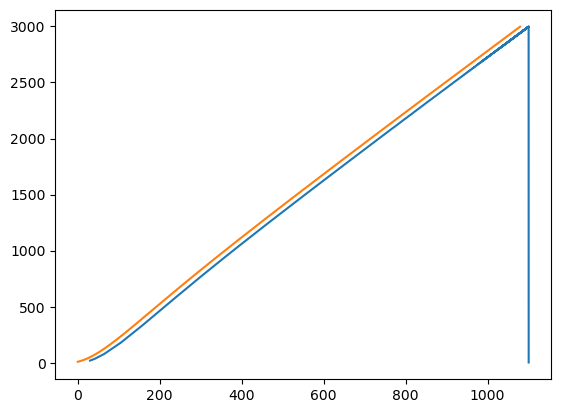

In [98]:
plt.plot(data["t"],data["y"][0])
plt.plot(My_Tk[1](z_array))

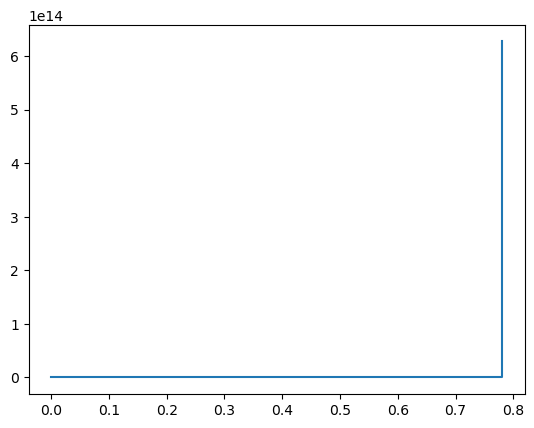

In [80]:
plt.plot(data["t"],data["y"][0])

In [16]:
# let's test this self-annihilation model:
z_array_Tk=np.arange(20,1100,0.01) 
My_Tk_DMAN=Tk_DMAN(z_array_Tk,1*10e-24)
My_Tk_DMAN2=Tk_DMAN(z_array_Tk,5*10e-24)
My_Tk_DMAN3=Tk_DMAN(z_array_Tk,2*10e-23)
My_Tk_DMAN4=Tk_DMAN(z_array_Tk,5*10e-23)
My_Tk_DMAN5=Tk_DMAN(z_array_Tk,1*10e-22)
My_Tk_DMAN6=Tk_DMAN(z_array_Tk,2*10e-22)


<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_501/401348974.py:14: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel(f"$\delta T_b$ $[mK]$")


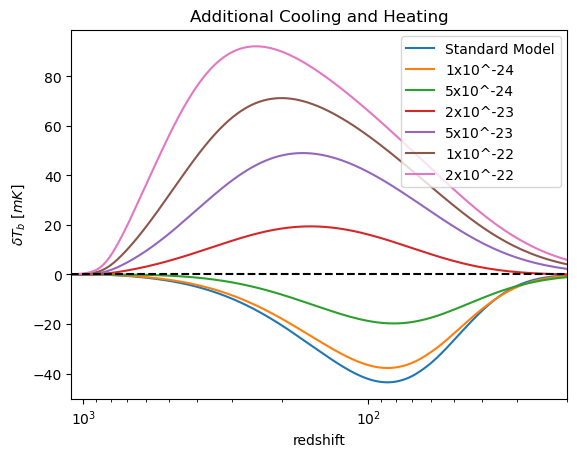

In [17]:
# Let's now plot these different models to see how they change the curve:
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk[1]),label="Standard Model")
# plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_cool[1]),label="Additional Cooling")
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN[1]),label="1x10^-24")
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN2[1]),label="5x10^-24")
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN3[1]),label="2x10^-23")
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN4[1]),label="5x10^-23")
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN5[1]),label="1x10^-22")
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN6[1]),label="2x10^-22")
plt.title(f"Additional Cooling and Heating")
# plt.axvline(85)
plt.xscale("log")
plt.xlabel("redshift")
plt.ylabel(f"$\delta T_b$ $[mK]$")
plt.axhline(ls="--",c="black")
plt.xlim(1100,20)
# plt.ylim(-85,20)
plt.legend()
plt.savefig("Self Annihilation")

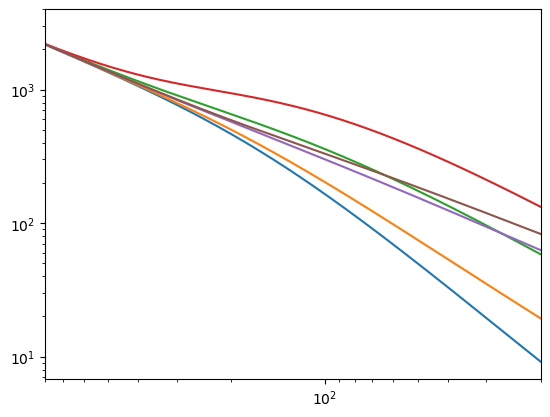

In [132]:
plt.plot(z_array, My_Tk[1](z_array))
plt.plot(z_array, My_Tk_DMAN2[1](z_array))
plt.plot(z_array, My_Tk_DMAN3[1](z_array))
plt.plot(z_array, My_Tk_DMAN4[1](z_array))
plt.plot(z_array, My_Tk_DMAN5[1](z_array))
plt.plot(z_array, My_Tk_DMAN6[1](z_array))
plt.xlim(800,20)
plt.xscale("log")
plt.yscale("log")

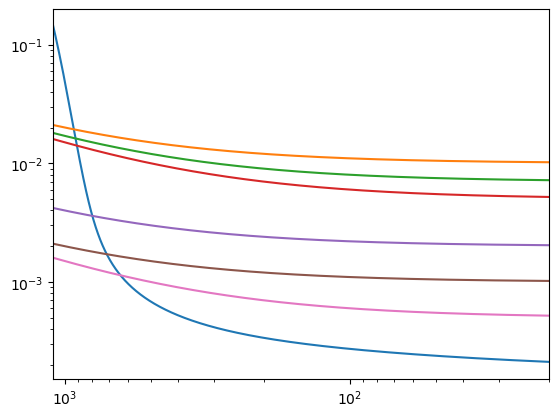

In [159]:
plt.plot(z_array,camb_xe_interp(z_array))
plt.plot(z_array,10e-6*z_array+0.01)
plt.plot(z_array,10e-6*z_array+0.007)
plt.plot(z_array,10e-6*z_array+0.005)
plt.plot(z_array,2e-6*z_array+0.002)
plt.plot(z_array,10e-7*z_array+0.001)
plt.plot(z_array,10e-7*z_array+0.0005)

plt.xscale("log")
plt.xlim(1100,20)
plt.yscale("log")

### The New Strategy (Cubicspines)
- Instead of replicating the graphs using the physics that isn't even neccesarily correct, let's just replicate the graphs using cubic splines to emulate their shape.  We'll then just input the critical points and call it good. However, we'll need to make sure it can emulate within the values that are graphed, not just the graphed values.  To do this, we can plot the critical points as a function of the input parameter and then interpolate this to get a rate of change for the x and y values of the critical points, allowing us to emulate any critical point within the given graphs.  We won't know the physics...except actually we will because we will know the parameter that best matches the graph which means we actually do know the physics.  This is a much better way to do this, though I'm sure there is a catch.  A big reason this works is because we have closed boundaries. We know the smallest parameter graph and the largest possible parameter graph.
- NOTE: Cubicsplines and Hermite Cublic Splines with dydx=0 don't quite work. They don't fit quite right. Need to create our own 5th order polynomials I think.

##### Let's try solving for the coefficients of a 5 term polynomial give our inflection and critical points.

- $y=Ax^{5}+Bx^{4}+Cx^{3}+Dx^{2}+Ex+F$

- $\frac{dy}{dx}=5Ax^{4}+4Bx^{3}+3Cx^{2}+2Dx+E$

- $\frac{d^{2}y}{dx^{2}}=20Ax^{3}+12Bx^{2}+6Cx+2D$

- $\left [\begin{array}{ccccc} 5x_{1}^{4} & 4x_{1}^{3} & 3x_{1}^{2} & 2x_{1} & 1  \\ 5x_{2}^{4} & 4x_{2}^{3} & 3x_{2}^{2} & 2x_{2} & 1 \\ 5x_{3}^{4} & 4x_{3}^{3} & 3x_{3}^{2} & 2x_{3} & 1 \\ 20x_{4}^{3} & 12x_{4}^{2} & 6x_{4} & 2 & 0 \\ 20x_{5}^{3} & 12x_{5}^{2} & 6x_{5} & 2 & 0 \end{array} \right]\left [\begin{array}{c} A\\ B \\ C \\ D \\ E\end{array} \right] = \left [\begin{array}{c} 0\\ 0 \\ 0 \\ 0 \\ 0\end{array} \right]$

where $x_{1}$ - $x_{3}$ are critical points and $x_{4}$ - $x_{5}$ are inflection points

Maybe this is not going to work. Not sure polynomials are going to have the correct shape

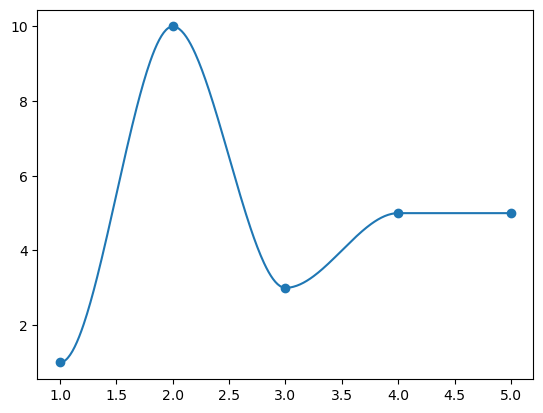

In [343]:
# Let's play around with cubic splines to see if we can get data that matches
import scipy.interpolate


x = [1,2,3,4,5]
y= [1,10,3,5,5]
poly = np.polyfit(x,y,len(x)-1)
x_array = np.arange(1,5,0.01)
interp = scipy.interpolate.CubicHermiteSpline(x,y,[0,0,0,0,0])
plt.scatter(x,y)
plt.plot(x_array,interp(x_array))


In [19]:
# We're going to to have to make our own polynomial. Let's start by understanding how np.linalg.solve works
a = np.array([[5,2],[3,3]])
b = np.array([[1],[2]])
np.linalg.solve(a,b)

array([[-0.11111111],
       [ 0.77777778]])

In [46]:
def make_matrix (crit_points):
    matrix_a = np.zeros((5,5))
    matrix_b = np.zeros((5,1))
    for i in np.arange(0,5):
        row_element = np.array([crit_points[i][0]**5,crit_points[i][0]**4,crit_points[i][0]**3,crit_points[i][0]**2,crit_points[i][0]])
        matrix_a[i] = row_element
        matrix_b[i] = crit_points[i][1]

    return matrix_a, matrix_b

In [51]:
a = make_matrix(cp_dman_test.cp_array)[0]
b = make_matrix(cp_dman_test.cp_array)[1]
np.linalg.solve(a,b)
np.poly?

Signature:       np.poly(seq_of_zeros)
Call signature:  np.poly(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function poly at 0x7fb9cc3d3380>
File:            ~/anaconda3/lib/python3.12/site-packages/numpy/lib/polynomial.py
Docstring:      
Find the coefficients of a polynomial with the given sequence of roots.

.. note::
   This forms part of the old polynomial API. Since version 1.4, the
   new polynomial API defined in `numpy.polynomial` is preferred.
   A summary of the differences can be found in the
   :doc:`transition guide </reference/routines.polynomials>`.

Returns the coefficients of the polynomial whose leading coefficient
is one for the given sequence of zeros (multiple roots must be included
in the sequence as many times as their multiplicity; see Examples).
A square matrix (or array, which will be treated as a matrix) can also
be given, in which case the coefficients of the characteristic polynomial
of the matrix are returned.

Parameters


In [44]:
np.zeros((5,1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [35]:
# Let's identify the critical points based on the graph from Novosyadlyj 2024 for self-annihilation
class Crit_Points:
    """Defines the parameter and critical points and inflection points associated with the model defined by that parameter"""
    def __init__(self,parameter,cp_array,ip_array):
        self.parameter = parameter
        self.cp_array = cp_array
        self.ip_array = ip_array

cp_dman1 = Crit_Points(1*10e-24,np.array([[np.log10(1100),0],[np.log10(84),-37],[np.log10(20),0]]),np.array([[np.log10(150),-15],[np.log10(35),-10]]))
cp_dman_test = Crit_Points(1*10e-24,np.array([[np.log10(1100),0],[np.log10(84),-37],[np.log10(20),0],[np.log10(150),-15],[np.log10(35),-10]]),0)

In [397]:
# Let's make an interpolation function for exactly what we were talking about earlier in the markdown.
def model_interpolator (Crit_Points):
    """Interpolates intermediary curves of a model based on a set of given curves
    
    Parameters
    ===============================================
    Crit_Points: A class that has the property of parameter and critical points array. See the Crit_Points class"""
    
    interpolated_model = scipy.interpolate.CubicHermiteSpline(Crit_Points.cp_array.transpose()[0][::-1],Crit_Points.cp_array.transpose()[1][::-1],np.zeros(len(Crit_Points.cp_array)))
    return interpolated_model
        

In [398]:
dman1 = model_interpolator(cp_dman1)

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_558/1884825590.py:6: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel(f"$\delta T_b$ $[mK]$")


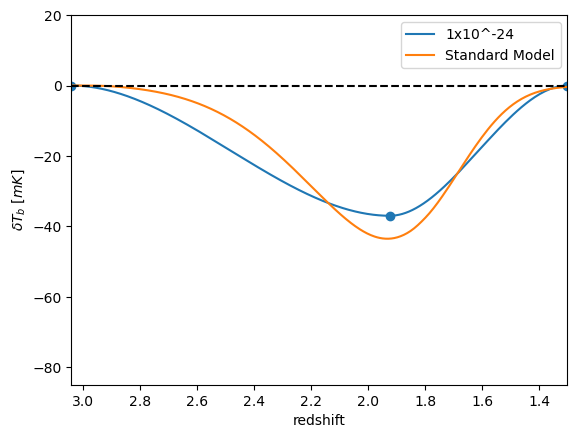

In [405]:
plt.scatter(cp_dman1.cp_array.transpose()[0],cp_dman1.cp_array.transpose()[1])
plt.plot(np.log10(z_array),dman1(np.log10(z_array)),label="1x10^-24")
plt.plot(np.log10(z_array),dTb(z_array,camb_xe_interp,My_Tk[1]),label="Standard Model")
# plt.xscale("log")
plt.xlabel("redshift")
plt.ylabel(f"$\delta T_b$ $[mK]$")
plt.axhline(ls="--",c="black")
plt.xlim(np.log10(1100),np.log10(20))
plt.ylim(-85,20)
plt.legend()

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_558/2726767752.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel(f"$\delta T_b$ $[mK]$")
/tmp/ipykernel_558/2726767752.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel(f"$\delta T_b$ $[mK]$")


ValueError: x and y must have same first dimension, but have shapes (1080,) and (1,)

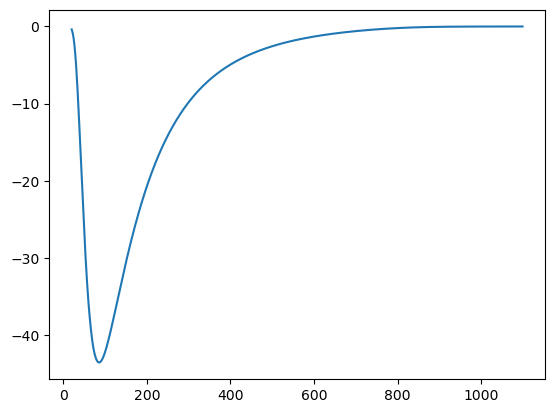

In [371]:
# Let's now plot these different models to see how they change the curve:
plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk[1]),label="Standard Model")
plt.plot(z_array,dman1,label="1x10^-24")
# plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN2[1]),label="5x10^-24")
# plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN3[1]),label="2x10^-23")
# plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN4[1]),label="5x10^-23")
# plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN5[1]),label="1x10^-22")
# plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk_DMAN6[1]),label="2x10^-22")
plt.title(f"Self Annihilation")
# plt.axvline(85)
plt.xscale("log")
plt.xlabel("redshift")
plt.ylabel(f"$\delta T_b$ $[mK]$")
plt.axhline(ls="--",c="black")
plt.xlim(1100,20)
# plt.ylim(-85,20)
plt.legend()
plt.savefig("Self Annihilation")

### Next troubleshooting step should be to focus on plotting T_k to get rid of the uneeded information in our trough here.

Talk to Julian Munos University of Texas.  See if he is doing the same thing. Seems like he's doing some analytical model of the Dark Ages as well.

# Appendices

### Comparing My T_k vs ComoRec's T_K

- Conclusion: Close enough (They are very close)

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_481/1653634865.py:10: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel(f"$\delta T_b$ $[mK]$")


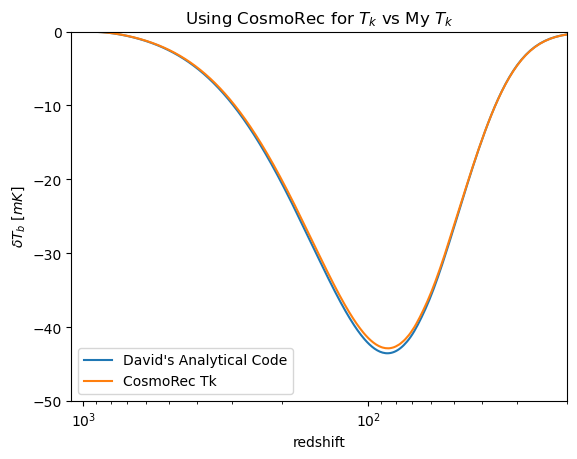

In [17]:
# comparing CosmoRec_TK to my Tk code:

plt.plot(z_array,dTb(z_array,camb_xe_interp,My_Tk[1]),label="David's Analytical Code")
# plt.plot(ARES_redshift,ARES_dTb, label="ARES")
plt.plot(z_array,dTb(z_array,CosmoRec_xe,CosmoRec_Tk),label="CosmoRec Tk")
plt.title(f"Using CosmoRec for $T_k$ vs My $T_k$")
# plt.axvline(85)
plt.xscale("log")
plt.xlabel("redshift")
plt.ylabel(f"$\delta T_b$ $[mK]$")
plt.xlim(1100,20)
plt.ylim(-50,0)
plt.legend()

In [18]:
# Let's compare the minimums and the locations of the minimums:
David_min=dTb(z_array,camb_xe_interp,My_Tk[1]).min()
David_redshift_min = z_array[np.where(dTb(z_array,camb_xe_interp,My_Tk[1])==David_min)]
print(f"David's code has a minimum of {David_min:.2f} mK at a redshift of {David_redshift_min[0]} or a frequency of {1420/(1+David_redshift_min[0]):.2f} MHz")

CosmoRec_min = dTb(z_array,CosmoRec_xe,CosmoRec_Tk)[15::].min()
CosmoRec_redshift_min = z_array[np.where(dTb(z_array,CosmoRec_xe,CosmoRec_Tk)==CosmoRec_min)]
print(f"CosmoRec has a minimum of {CosmoRec_min:.2f} mK at a redshift of {CosmoRec_redshift_min[0]} or a frequency of {1420/(1+CosmoRec_redshift_min[0]):.2f} MHz")

David's code has a minimum of -43.53 mK at a redshift of 86 or a frequency of 16.32 MHz
CosmoRec has a minimum of -42.86 mK at a redshift of 85 or a frequency of 16.51 MHz


### Comparing different seeds of 21cmFAST
- Conclusion: They aren't different. 100Mpc is enough to smooth out the average to be a very good representation of the universe

In [ ]:
#### Let's see if changing the seed make it any different ####
###NOTE: Different seed changes nothing. 100 Mpc is enough to capture the true average of the universe. ###
# Now let's compare to 21cmFAST

# 21 cm FAST seems to not appreciate any z value (redshift) of 500 or more. Puts the lower limit of the 
# frequency at around 3 MHZ.  Ideal would be 1 MHz, but LuSEE-Night is at 5 MHz, so I suppose that will
# be fine.  May want to look into getting that down to 1 somehow someday, but not right now.
### for converting from redshift to frequency
# frequencies_21cm = np.arange(3,200)  # avoiding anything below 2.5 MHZ
# z = lambda f: 1420.4/f-1
# z_array = np.array([])
# for i in frequencies_21cm:
#     element = z(i)
#     z_array=np.append(z_array,element)
# Now let's plug in the redshifts
z_array_21cmfast=np.arange(20,1100)
coeval_boxes = p21c.run_coeval(
    redshift = list(z_array_21cmfast[0:450]),
    user_params = {"HII_DIM": 100, "BOX_LEN": 100, "USE_INTERPOLATION_TABLES": True},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8159,hlittle=h,OMm=omM0,OMb=omB0,POWER_INDEX=ns),
    astro_params = p21c.AstroParams(),
    flag_options = {'USE_TS_FLUCT':True},
    random_seed=67899)
# Let's make our 21cm curve from the data!
global21cm_array2=np.array([])
for i in range(len(z_array[0:450])):
    element=coeval_boxes[i].brightness_temp.mean()
    global21cm_array2=np.append(global21cm_array2,element)

# This will plot our data over our frequencies_21cm / or z array (depending on what I'm doing)
# fig=plt.figure(figsize=(20,5))
# plt.plot(z_array[0:450],global21cm_array)
# plt.xlabel(r'redshift',size=15)
# plt.ylabel(r'Temperature Residual $\delta T_{b} (mK)$',size=15)
# plt.title("Global 21-cm Signal", size = 20)
# plt.show()

In [ ]:
 FAST_interp2 = scipy.interpolate.CubicSpline(z_array_21cmfast[0:450],global21cm_array2)

### Coding Up $T_{k}$ (Appendix)

That's all well and good, but now let's code up a $T_{k}$ that doesn't rely on CosmoRec. Need to code up the following equations:

- $\frac{dT_{k}}{dz} = \frac{1}{H(1+z)}[2T_{k}H-\frac{x_{e}}{1+f_{He}+x_{e}}\frac{(T_{\gamma}-T_{k})}{t_{c}}] $ 

- $t_{c} = (\frac{8}{3m_{e}c}\sigma_{T}a_{rad}T_{\gamma}^{4})^{-1} = 1.2 \times 10^{8}(\frac{1+z}{10})^{-4}$

- $T_{\gamma} = T_{\gamma,0}(1+z)$

- $H=H_{0}(1+z)\sqrt{\Omega_{0,\gamma}(1+z)^{2}+\Omega_{0,M}(1+z)+\Omega_{0,K}+\Omega_{0,\Lambda}(1+z)^{-2}}$

ISSUE #1: The reason compton heating wins out over adiabatic cooling is because the temperature will drop some amount, and THEN compton heating will kick in very quickly.  This means in order to perfectly numerically model this, your grid size would have to be unbelievably small.  Seriously, that compton heating is orders of magnitude more important only after a few milliKelvin degrees of change.

SOLUTION #1: We can estimate this by comparing the two rates and just setting it equal to one or the other until some arbitrarily small difference between the two. I think this will work great as long as we allow for a very small difference to evolve the system.

ISSUE #2: We've been using this:
- $\frac{dT_{k}}{dt} = \frac{x_{e}}{1+x_{e}}\frac{(T_{\gamma,0}(1+z)-T_{k})}{t_{c}}-2T_{k}H$ (17)
but that is technically an estimation of a purely hydrogen gas. Remember that 24% of this gas is Helium. If all of the gas were Helium instead of a 1 in the denominator, we would have a 0.5. To understand why, consider a fully ionized Helium gas. Your $\frac{x_{e}}{0.5+x_{e}}$ would be 2/3 for a fully ionized fraction of 1. Makes sense since two out of every three particles would be electrons now, not just half. 

In [ ]:


def Tk (z_array):
    """Creates an array evolving the IGM temperature based on adiabatic cooling and compton scattering. Only works for the cosmic 
    Dark Ages, as it does not include UV
    
    ===================================================================
    Parameters
    ===================================================================
    z_array: an array of increasing redshift values
    ===================================================================
    Output
    ===================================================================
    Tk_array:  A 2-D array with each entry being the redshift and IGM temperature"""
### Let's code up T_k
    num=len(z_array)
    t_c = lambda z: 1.2e8*((1+z)/10)**(-4) * 3.154e7 #[seconds] timescale of compton scattering
    T_gamma = lambda z: T_gamma0*(1+z)   # evolution of the CMB temp
    H = lambda z: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(omL0/((1+z)**2)))  # Hubble flow function with a conversion factor
    # zlog = np.logspace(np.log10(z_array[0]),np.log10(z_array[-1]),num=num)[::-1]
    # zlog = np.append(zlog,0)
    zlog = z_array[::-1]
    T = T_gamma(z_array[-1])   # your initial temperature at the highest redshift. This assumes it is coupled fully to the CMB at that time.
    ze = z_array[-1]           # defines your starting z (useful for the loop below)
    x_e = camb_xe_interp   # this is our model for fraction of free electrons
    Tk_array = np.zeros((num-1,2))
    for i in range(num-1):
        zs = ze
        ze = zlog[i+1]
        adiabatic = lambda zs,T:(1/(H(zs)*(1+zs)))*(2*H(zs)*T)*(ze-zs)
        compton = lambda zs,T: (1/(H(zs)*(1+zs)))*((x_e(zs))/(1+x_e(zs)))*((T_gamma(zs)-T)/(t_c(zs)))*(ze-zs)
        T += adiabatic(zs,T)-compton(zs,T)
        Tk_array[i][0] = ze
        Tk_array[i][1] = T
    Tk_function=scipy.interpolate.CubicSpline(Tk_array.transpose()[0][::-1],Tk_array.transpose()[1][::-1])  # Turns our output into a function with redshift as an argument    
    return Tk_array, Tk_function



Let's do some testing of this function against CosmoRec

In [28]:
# let's test out a more finely gridded z_array
z_array=np.arange(20,1100,0.001)
data=Tk(z_array)


In [23]:
z_array.shape

(1080000,)

Text(0.5, 0, 'redshift')

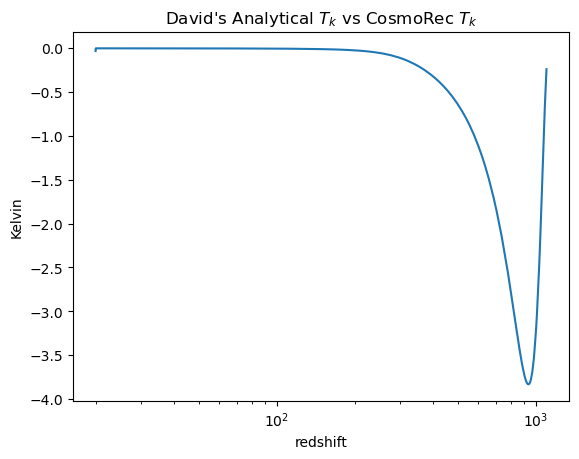

In [24]:
# let's compare our code to CosmoRec:
# test1 = np.append(data.transpose()[1],9.45)
plt.plot(z_array,CosmoRec_Tk(z_array)[::-1]-data[1](z_array[::-1]))
plt.title(f"David's Analytical $T_k$ vs CosmoRec $T_k$")
plt.xscale("log")
plt.ylabel("Kelvin")
plt.xlabel("redshift")
# plt.xlim(20,300)
# plt.ylim(-1,0)

(20, 300)

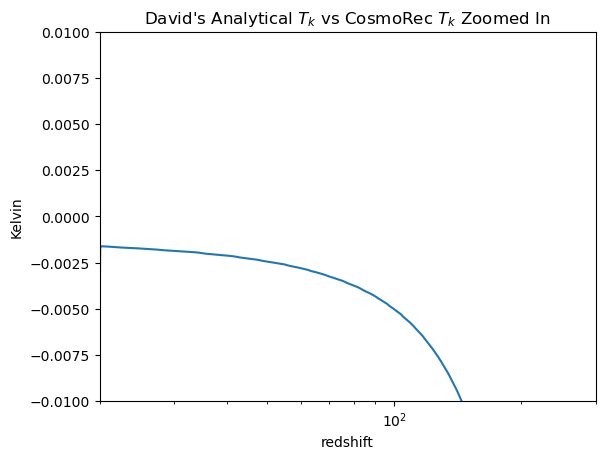

In [25]:
# Zoom in
# test1 = data.transpose()[1]
# test1 = np.append(test1,9.47)  # just need to add some value to the end of our data to get it to the same size as CosmoRec
plt.plot(z_array,CosmoRec_Tk(z_array)[::-1]-data[1](z_array[::-1]))
plt.title(f"David's Analytical $T_k$ vs CosmoRec $T_k$ Zoomed In")
plt.xscale("log")
plt.ylabel("Kelvin")
plt.xlabel("redshift")
plt.ylim(-0.01,0.01)
plt.xlim(20,300)
# plt.axvline(85)
# plt.axhline(-0.0037)

In [26]:
CosmoRec_Tk(z_array)[::-1]-derp

NameError: name 'derp' is not defined

In [ ]:
derp = data.transpose()[1]
derp = np.append(derp,9.47)

In [ ]:

zlog = np.logspace(np.log10(z_array[0]),np.log10(z_array[-1]),num=1000)[::-1]
xe_raw = camb_data.get_background_redshift_evolution(zlog, ["x_e"], format="array")
x_e = scipy.interpolate.interp1d(zlog,xe_raw.flatten())
z = 1097
T = 2990.775
temp = lambda z: (1/(H(z)*(1+z)))*(2*H(z)*T-((x_e(z))/(1+x_e(z)))*((T_gamma(z)-T)/(t_c)))
print(temp(z)-2*T_gamma0)


-0.0023231838560757723


2.724999999999909

array([0.00021222])

/tmp/ipykernel_588/2734760988.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tk_array[i][1] = T


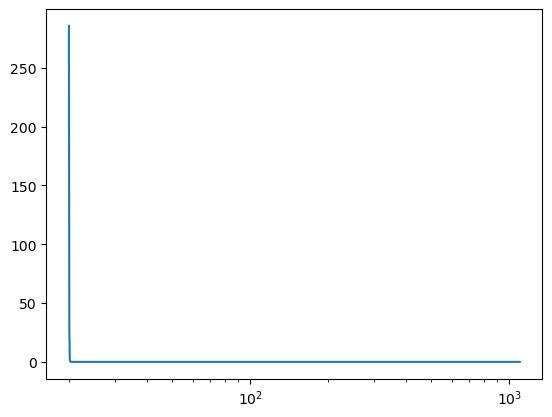

In [ ]:
plt.plot(Tk(z_array).transpose()[0],Tk(z_array).transpose()[1])
plt.xscale("log")


3000.225

In [ ]:
H0*3.24078e-20
# test_data_raw=dTkdz(z_array)
# test_data = scipy.interpolate.CubicSpline(test_data_raw.transpose()[0],test_data_raw.transpose()[1])

2.182989408e-18

In [ ]:
test_data_raw[0]

array([2.00000000e+01, 1.25924291e+05])

In [ ]:
T_gamma(20)

57.225

In [ ]:
z=1100
T=3000
x_e = camb_xe
tc=t_c
(1/H(z)*(1+z))*(2*H(z)*T-((x_e[i])/(1+x_e[i]))*((T_gamma(z)-T)/(tc)))

array([6606000.])

1507139.1363010467

### OLD STEP 1: Change ARES Cosmological Parameters.

In [7]:
cosmology=ares.ares.physics.Cosmology()

In [8]:
cosmology._planck_raw["H0"] = 20
cosmology._planck_raw["omega_m_0"]

KeyError: 'omega_m_0'

In [23]:
cosmology._planck_raw["H0"]

20

In [93]:
# let's see if we can extract cooling rates:
cooling_rates = np.array([])
x_vals = np.arange(1,100,0.1)
for i in x_vals:
    element = cosmology.cooling_rate(i)
    cooling_rates = np.append(cooling_rates,element)

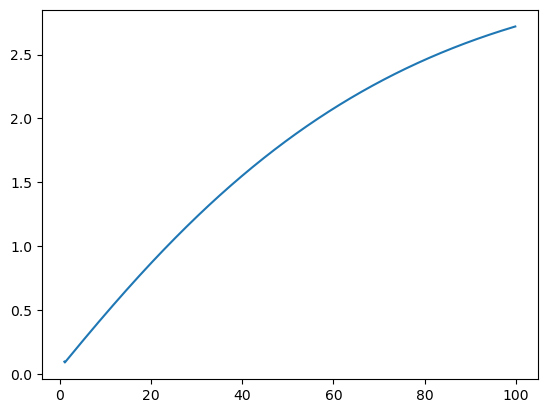

In [94]:
plt.plot(x_vals,cooling_rates)

So from here we know how to extract the cooling rates, but can we reassign these rates and have ARES run a different sim?

In [3]:
cosmo_sig=ares.simulations.Global21cm?
cosmo_sig.run()

NameError: name 'cosmo_sig' is not defined

Init signature: ares.simulations.Global21cm(**kwargs)
Docstring:     
This class must be inherited by another class, which need only have the
``pf`` attribute.

The three most (only) important parameters are:
    blob_names
    blob_ivars
    blob_funcs
    
Init docstring:
Set up a two-zone model for the global 21-cm signal.

..note :: This is essentially a MultiPhaseMedium calculation, except
    the Lyman alpha background and 21-cm background are calculated,
    and alternative (phenomenological) parameterizations such as a
    tanh for the ionization, thermal, and LW background evolution,
    may be used.
File:           ~/ares/ares/simulations/Global21cm.py
Type:           type
Subclasses:     

In [ ]:
cosmo_sig.cosm

TypeError: 'Cosmology' object is not subscriptable

In [3]:
dTb=cosmo_sig.history["dTb"][10]
z=cosmo_sig.history["z"]

In [ ]:
# Now let's compare this to ARES:
sim = ares.simulations.Global21cm()
sim.run()
ARES_redshift=sim.history["z"]     # grabs ARES redshift
ARES_dTb = sim.history["dTb"]     # grabs ARES dTb
ARES_dTb = np.delete(ARES_dTb,996)
ARES_redshift = np.delete(ARES_redshift,996)   # this is a wierd point in ARES that stops the CubicSpline from working

-8.678422985589948e-06

In [6]:
pip install pycamb

ERROR: Could not find a version that satisfies the requirement pycamb (from versions: none)
ERROR: No matching distribution found for pycamb
Note: you may need to restart the kernel to use updated packages.


In [8]:
import camb

In [9]:
from hmf import MassFunction

In [11]:
hmf.wdm.MassFunctionWDM

hmf.alternatives.wdm.MassFunctionWDM

In [2]:
def_kwargs = \
{
 "hmf_model": 'PS',
 "hmf_logMmin": 4,
 "hmf_logMmax": 18,
 "hmf_dlogM": 0.01,

 "hmf_fmt": 'hdf5',
 "hmf_table": None,
 "hmf_wdm_mass": None,

 #"hmf_window": 'sharpk',

 # Redshift sampling
 "hmf_zmin": 0.,
 "hmf_zmax": 60.,
 "hmf_dz": 0.05,

 # Can do constant timestep instead of constant dz
 #"hmf_dt": 1,
 #"hmf_tmin": 30.,
 #"hmf_tmax": 1000.,

 # Cosmology
 "cosmology_id": 'best',
 "cosmology_name": 'planck_TTTEEE_lowl_lowE',

 #HMF params and filter params are for doing Aurel Schneider's 2015 paper WDM.
 #"hmf_params" : {'a' : 1.0},
 #"filter_params" : {'c' : 2.5}

 #"cosmology_id": 'paul',
 #"cosmology_name": 'user',
 "sigma_8": 0.8159,
 'primordial_index': 0.9652,
 'omega_m_0': 0.315579,
 'omega_b_0': 0.0491,
 'hubble_0': 0.6726,
 'omega_l_0': 1. - 0.315579,

}

##

kwargs = def_kwargs.copy()

hmf = ares.physics.HaloMassFunction(hmf_analytic=False,
    hmf_load=False, **kwargs)

In [3]:
import hmf

In [ ]:
### I'm not going to mess with this just yet. It's a much better way to get x_e that doesn't require an outside program (all through python)

#set_params is a shortcut routine for setting many things at once
pars = camb.set_params(H0=H0, ombh2=omb*h**2, omch2=omc*h**2, As=As, ns=ns)
data= camb.get_background(pars)
#or as a function of redshift
camb_xe = data.get_background_redshift_evolution(z_array, ['x_e'], format='array')
plt.plot(z_array,back_ev)

(0.0, 5.0)

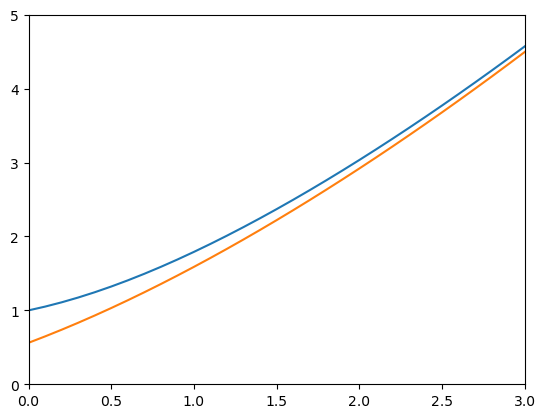

In [101]:
# Comparing Hubble flow with and without dark energy
H2 = lambda z: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(0/((1+z)**2)))
plt.plot(np.arange(0,1000,0.1),H(np.arange(0,1000,0.1))/(H0*3.24078e-20))
plt.plot(np.arange(0,1000,0.1),H2(np.arange(0,1000,0.1))/(H0*3.24078e-20))
plt.xlim(0,3)
plt.ylim(0,5)

In [ ]:
camb.dark_energy.DarkEnergyModel.

Init signature: camb.dark_energy.DarkEnergyModel(*args, **kwargs)
Docstring:      Abstract base class for dark energy model implementations.
File:           ~/anaconda3/lib/python3.12/site-packages/camb/dark_energy.py
Type:           CAMBStructureMeta
Subclasses:     DarkEnergyEqnOfState, AxionEffectiveFluid, Quintessence

In [ ]:
########### Begin troubleshooting difference in Tk #######################

In [ ]:
My_Tk[1](200)
CosmoRec_Tk(200)
H = lambda z: (H0*3.24078e-20)*(1+z)*np.sqrt(omR0*(1+z)**2+omM0*(1+z)+omK0+(omL0/((1+z)**2)))
2*H(100)

2.522087898927213e-15

In [ ]:
t_c = lambda z: 1.172e8*((1+z)/10)**(-4) * 3.154e7 #[seconds] timescale of compton scattering
z = 20
(T_gamma0*(1+z-)/t_c(z)

5.2612371526703194e-15

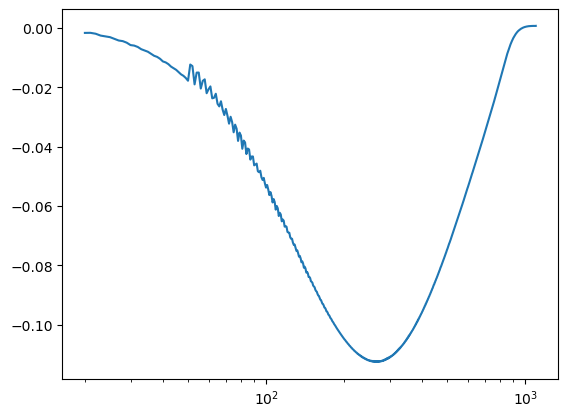

In [ ]:
plt.plot(z_array,CosmoRec_Tk(z_array)-My_Tk[1](z_array))
plt.xscale("log")

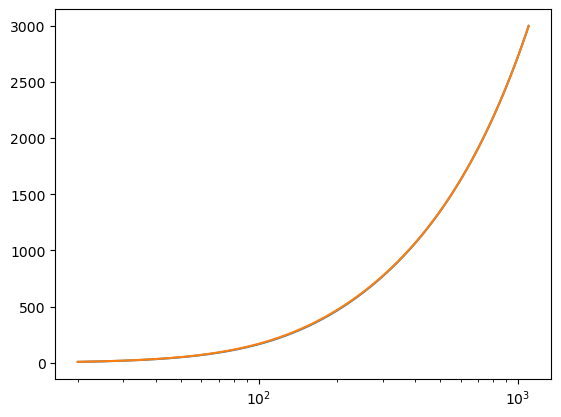

In [ ]:
plt.plot(z_array,CosmoRec_Tk(z_array))
plt.plot(z_array,My_Tk[1](z_array))
# plt.yscale("log")
plt.xscale("log")

### CAMB Stuff (understanding a few of its methods)

In [14]:

camb_test = camb_data.get_background_redshift_evolution(z_array, ["T_b"], format="array") # this is T_k
camb_test_interp=scipy.interpolate.CubicSpline(z_array,camb_test.flatten())

Text(0, 0.5, 'delta Kelvin')

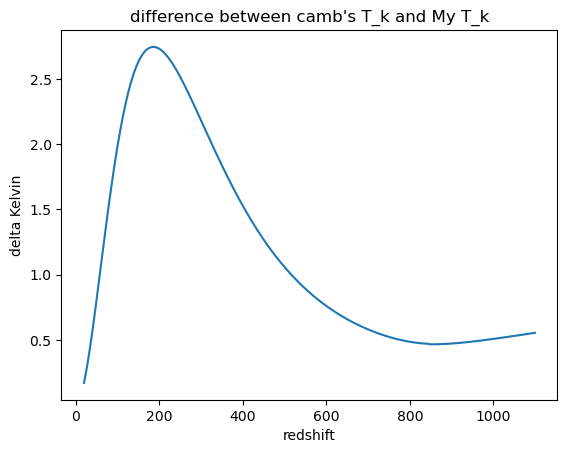

In [76]:
plt.plot(z_array,camb_test.flatten()-My_Tk[1](z_array))
# plt.plot(z_array,My_Tk[1](z_array))
plt.title("difference between camb's T_k and My T_k")
plt.xlabel("redshift")
plt.ylabel("delta Kelvin")

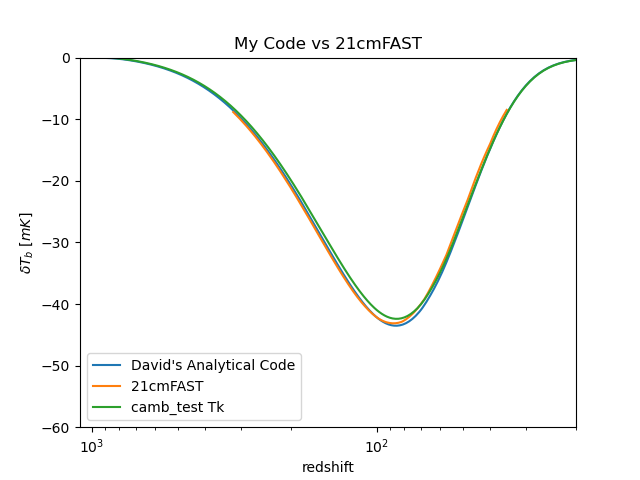

In [79]:
camb_test2 = camb_data.get_background_redshift_evolution(z_array, ['cs2b'], format="array")

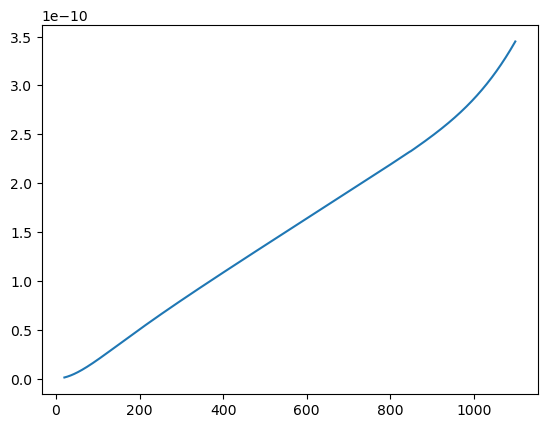

In [81]:
plt.plot(z_array, camb_test2.flatten())

In [107]:
params=camb.set_params(Do21cm=True)
params=camb.set_params()
params.Evolve_delta_Ts=True
camb.set_params
params=camb.set_params(ombh2=omB0*h**2,H0=H0,Evolve_delta_Ts=True)
camb_test2=camb.get_background(params)

In [121]:
background=camb_test2.calc_power_spectra(params)

Type:        NoneType
String form: None
Docstring:   <no docstring>